In [ ]:
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/Shareddrives/IITB_Bosch/Yolov5_DeepSort

/content/drive/Shareddrives/IITB_Bosch/Yolov5_DeepSort


In [ ]:
pip install -r ./Yolov5_DeepSort_Pytorch/requirements.txt

     |████████████████████████████████| 596 kB 5.1 MB/s 
     |████████████████████████████████| 5.8 MB 41.4 MB/s 
     |████████████████████████████████| 64 kB 2.6 MB/s 
     |████████████████████████████████| 190 kB 45.7 MB/s 
     |████████████████████████████████| 42 kB 774 kB/s 
     |████████████████████████████████| 42 kB 886 kB/s 
     |████████████████████████████████| 64 kB 2.6 MB/s 
     |████████████████████████████████| 73 kB 1.7 MB/s 
     |████████████████████████████████| 68 kB 6.6 MB/s 
     |████████████████████████████████| 41 kB 626 kB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
%cd Yolov5_DeepSort_Pytorch/

/content/drive/Shareddrives/IITB_Bosch/Yolov5_DeepSort/Yolov5_DeepSort_Pytorch


In [ ]:
!pip install pafy
!pip install youtube_dl==2020.12.2

     |████████████████████████████████| 1.8 MB 5.2 MB/s 


In [ ]:
class Arguments():
    pass

In [ ]:
# limit the number of cpus used by high performance libraries
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import sys
sys.path.insert(0, './yolov5')

import argparse
import os
import platform
import shutil
import time
from pathlib import Path
import cv2
import torch
import torch.backends.cudnn as cudnn

from yolov5.models.experimental import attempt_load
from yolov5.utils.downloads import attempt_download
from yolov5.models.common import DetectMultiBackend
from yolov5.utils.datasets import LoadImages, LoadStreams
from yolov5.utils.general import (LOGGER, check_img_size, non_max_suppression, scale_coords, 
                                  check_imshow, xyxy2xywh, increment_path)
from yolov5.utils.torch_utils import select_device, time_sync
from yolov5.utils.plots import Annotator, colors
from deep_sort.utils.parser import get_config
from deep_sort.deep_sort import DeepSort

FILE = Path("/content/drive/Shareddrives/IITB_Bosch/Yolov5_DeepSort/Yolov5_DeepSort_Pytorch/track.py").resolve() #__file__
ROOT = FILE.parents[0]  # yolov5 deepsort root directory
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative


def detect(opt):
    out, source, yolo_model, deep_sort_model, show_vid, save_vid, save_txt, imgsz, evaluate, half, project, name, exist_ok= \
        opt.output, opt.source, opt.yolo_model, opt.deep_sort_model, opt.show_vid, opt.save_vid, \
        opt.save_txt, opt.imgsz, opt.evaluate, opt.half, opt.project, opt.name, opt.exist_ok
    webcam = source == '0' or source.startswith(
        'rtsp') or source.startswith('http') or source.endswith('.txt')

    device = select_device(opt.device)
    # initialize deepsort
    cfg = get_config()
    cfg.merge_from_file(opt.config_deepsort)
    deepsort = DeepSort(deep_sort_model,
                        device,
                        max_dist=cfg.DEEPSORT.MAX_DIST,
                        max_iou_distance=cfg.DEEPSORT.MAX_IOU_DISTANCE,
                        max_age=cfg.DEEPSORT.MAX_AGE, n_init=cfg.DEEPSORT.N_INIT, nn_budget=cfg.DEEPSORT.NN_BUDGET,
                        )

    # Initialize
    half &= device.type != 'cpu'  # half precision only supported on CUDA

    # The MOT16 evaluation runs multiple inference streams in parallel, each one writing to
    # its own .txt file. Hence, in that case, the output folder is not restored
    if not evaluate:
        if os.path.exists(out):
            pass
            shutil.rmtree(out)  # delete output folder
        os.makedirs(out)  # make new output folder

    # Directories
    exp_name = yolo_model.split(".")[0] if type(yolo_model) is str else "ensemble"
    exp_name = exp_name + "_" + deep_sort_model
    save_dir = increment_path(Path(project) / exp_name, exist_ok=exist_ok)  # increment run if project name exists
    save_dir.mkdir(parents=True, exist_ok=True)  # make dir

    # Load model
    device = select_device(device)
    model = DetectMultiBackend(yolo_model, device=device, dnn=opt.dnn)
    stride, names, pt, jit, _ = model.stride, model.names, model.pt, model.jit, model.onnx
    imgsz = check_img_size(imgsz, s=stride)  # check image size

    # Half
    half &= pt and device.type != 'cpu'  # half precision only supported by PyTorch on CUDA
    if pt:
        model.model.half() if half else model.model.float()

    # Set Dataloader
    vid_path, vid_writer = None, None
    # Check if environment supports image displays
    if show_vid:
        show_vid = check_imshow()

    # Dataloader
    if webcam:
        show_vid = check_imshow()
        cudnn.benchmark = True  # set True to speed up constant image size inference
        dataset = LoadStreams(source, img_size=imgsz, stride=stride, auto=pt and not jit)
        bs = len(dataset)  # batch_size
    else:
        dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt and not jit)
        bs = 1  # batch_size
    vid_path, vid_writer = [None] * bs, [None] * bs

    # Get names and colors
    names = model.module.names if hasattr(model, 'module') else model.names

    # extract what is in between the last '/' and last '.'
    txt_file_name = source.split('/')[-1].split('.')[0]
    txt_path = str(Path(opt.save_dir)) + '/' + txt_file_name + '.txt'
    with open(txt_path, 'w') as f:
      pass

    if pt and device.type != 'cpu':
        model(torch.zeros(1, 3, *imgsz).to(device).type_as(next(model.model.parameters())))  # warmup
    dt, seen = [0.0, 0.0, 0.0, 0.0], 0
    for frame_idx, (path, img, im0s, vid_cap, s) in enumerate(dataset):
        t1 = time_sync()
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)
        t2 = time_sync()
        dt[0] += t2 - t1

        # Inference
        visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if opt.visualize else False
        pred = model(img, augment=opt.augment, visualize=visualize)
        t3 = time_sync() 
        dt[1] += t3 - t2

        # Apply NMS
        pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, opt.classes, opt.agnostic_nms, max_det=opt.max_det)
        dt[2] += time_sync() - t3

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            seen += 1
            if webcam:  # batch_size >= 1
                p, im0, _ = path[i], im0s[i].copy(), dataset.count
                s += f'{i}: '
            else:
                p, im0, _ = path, im0s.copy(), getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(Path(opt.save_dir)) + '/' + txt_file_name + '.mp4'

            s += '%gx%g ' % img.shape[2:]  # print string

            annotator = Annotator(im0, line_width=2, pil=not ascii)

            if det is not None and len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(
                    img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                xywhs = xyxy2xywh(det[:, 0:4])
                confs = det[:, 4]
                clss = det[:, 5]

                # pass detections to deepsort
                t4 = time_sync()
                outputs = deepsort.update(xywhs.cpu(), confs.cpu(), clss.cpu(), im0)
                t5 = time_sync()
                dt[3] += t5 - t4

                # draw boxes for visualization
                if len(outputs) > 0:
                    for j, (output, conf) in enumerate(zip(outputs, confs)):

                        bboxes = output[0:4]
                        id = output[4]
                        cls = output[5]

                        c = int(cls)  # integer class
                        label = f'{id} {names[c]} {conf:.2f}'
                        annotator.box_label(bboxes, label, color=colors(c, True))

                        if save_txt:
                            # to MOT format
                            bbox_left = output[0]
                            bbox_top = output[1]
                            bbox_w = output[2] - output[0]
                            bbox_h = output[3] - output[1]
                            # Write MOT compliant results to file
                            with open(txt_path, 'a') as f:
                                f.write(('%g ' * 10 + '\n') % (frame_idx + 1, id, bbox_left,  # MOT format
                                                               bbox_top, bbox_w, bbox_h, conf, -1, -1, -1))

                LOGGER.info(f'{s}Done. YOLO:({t3 - t2:.3f}s), DeepSort:({t5 - t4:.3f}s)')

            else:
                deepsort.increment_ages()
                LOGGER.info('No detections') 

            # Stream results
            im0 = annotator.result()
            if show_vid:
                cv2.imshow(str(p), im0)
                if cv2.waitKey(1) == ord('q'):  # q to quit
                    raise StopIteration

            # Save results (image with detections)
            if save_vid:
                if vid_path != save_path:  # new video
                    vid_path = save_path
                    if isinstance(vid_writer, cv2.VideoWriter):
                        vid_writer.release()  # release previous video writer
                    if vid_cap:  # video
                        fps = vid_cap.get(cv2.CAP_PROP_FPS)
                        w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                        h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                    else:  # stream
                        fps, w, h = 30, im0.shape[1], im0.shape[0]

                    vid_writer = cv2.VideoWriter(vid_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                vid_writer.write(im0)

    # Print results
    t = tuple(x / seen * 1E3 for x in dt)  # speeds per image
    LOGGER.info(f'Speed: %.1fms pre-process, %.1fms inference, %.1fms NMS, %.1fms deep sort update \
        per image at shape {(1, 3, *imgsz)}' % t)
    if save_txt or save_vid:
        print('Results saved to %s' % vid_path)
        print('Results saved to %s' % txt_path)
        if platform == 'darwin':  # MacOS
            os.system('open ' + save_path)

def track(yolo_model='yolov5m.pt', deep_sort_model='osnet_ibn_x1_0_MSMT17', source='0', output='inference/output', imgsz=[640], conf_thres=0.5,
            iou_thres=0.5, fourcc='mp4v', device='', show_vid=False, save_vid=False, save_txt=False, classes=0, agnostic_nms=False, augment=False,
            evaluate=False, config_deepsort='deep_sort/configs/deep_sort.yaml', half=False, visualize=False, max_det=1000, dnn=False, project= ROOT / 'runs/track',
            name='exp', exist_ok=False, save_dir='./results'):

opt = Arguments()
opt.yolo_model = "yolov5m.pt"
opt.deep_sort_model = "osnet_ibn_x1_0_MSMT17"
opt.source = '0'
opt.output = 'inference/output',
opt.imgsz = [640],
opt.conf_thres = 0.5,
opt.iou_thres = 0.5,
opt.fourcc = 'mp4v',
opt.device = '',
opt.show_vid = False,
opt.save_vid = False,
opt.save_txt = False,
opt.classes = 0,
opt.agnostic_nms = False,
opt.augment = False,
opt.evaluate = False,
opt.config_deepsort = 'deep_sort/configs/deep_sort.yaml',
opt.half = False,
opt.visualize = False,
opt.max_det = 1000,
opt.dnn = False,
opt.project =  ROOT / 'runs/track'
opt.name = 'exp',
opt.exist_ok = False,
opt.save_dir = './results'

    opt.imgsz *= 2 if len(opt.imgsz) == 1 else 1  # expand 

    with torch.no_grad():
        detect(opt)



'''
if __name__ == '__main__':

    main()

    
    parser = argparse.ArgumentParser()
    parser.add_argument('--yolo_model', nargs='+', type=str, default='yolov5m.pt', help='model.pt path(s)')
    parser.add_argument('--deep_sort_model', type=str, default='osnet_ibn_x1_0_MSMT17')
    parser.add_argument('--source', type=str, default='0', help='source')  # file/folder, 0 for webcam
    parser.add_argument('--output', type=str, default='inference/output', help='output folder')  # output folder
    parser.add_argument('--imgsz', '--img', '--img-size', nargs='+', type=int, default=[640], help='inference size h,w')
    parser.add_argument('--conf-thres', type=float, default=0.5, help='object confidence threshold')
    parser.add_argument('--iou-thres', type=float, default=0.5, help='IOU threshold for NMS')
    parser.add_argument('--fourcc', type=str, default='mp4v', help='output video codec (verify ffmpeg support)')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--show-vid', action='store_true', help='display tracking video results')
    parser.add_argument('--save-vid', action='store_true', help='save video tracking results')
    parser.add_argument('--save-txt', action='store_true', help='save MOT compliant results to *.txt')
    # class 0 is person, 1 is bycicle, 2 is car... 79 is oven
    parser.add_argument('--classes', nargs='+', type=int, help='filter by class: --class 0, or --class 16 17')
    parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
    parser.add_argument('--augment', action='store_true', help='augmented inference')
    parser.add_argument('--evaluate', action='store_true', help='augmented inference')
    parser.add_argument("--config_deepsort", type=str, default="deep_sort/configs/deep_sort.yaml")
    parser.add_argument("--half", action="store_true", help="use FP16 half-precision inference")
    parser.add_argument('--visualize', action='store_true', help='visualize features')
    parser.add_argument('--max-det', type=int, default=1000, help='maximum detection per image')
    parser.add_argument('--dnn', action='store_true', help='use OpenCV DNN for ONNX inference')
    parser.add_argument('--project', default=ROOT / 'runs/track', help='save results to project/name')
    parser.add_argument('--name', default='exp', help='save results to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--save-dir', default='./results', help='directory to save')

    opt = parser.parse_args()
    opt.imgsz *= 2 if len(opt.imgsz) == 1 else 1  # expand

    with torch.no_grad():
        detect(opt)
    '''


'\nif __name__ == \'__main__\':\n\n    main()\n\n    \n    parser = argparse.ArgumentParser()\n    parser.add_argument(\'--yolo_model\', nargs=\'+\', type=str, default=\'yolov5m.pt\', help=\'model.pt path(s)\')\n    parser.add_argument(\'--deep_sort_model\', type=str, default=\'osnet_ibn_x1_0_MSMT17\')\n    parser.add_argument(\'--source\', type=str, default=\'0\', help=\'source\')  # file/folder, 0 for webcam\n    parser.add_argument(\'--output\', type=str, default=\'inference/output\', help=\'output folder\')  # output folder\n    parser.add_argument(\'--imgsz\', \'--img\', \'--img-size\', nargs=\'+\', type=int, default=[640], help=\'inference size h,w\')\n    parser.add_argument(\'--conf-thres\', type=float, default=0.5, help=\'object confidence threshold\')\n    parser.add_argument(\'--iou-thres\', type=float, default=0.5, help=\'IOU threshold for NMS\')\n    parser.add_argument(\'--fourcc\', type=str, default=\'mp4v\', help=\'output video codec (verify ffmpeg support)\')\n    pars

In [ ]:
track(source="/content/drive/Shareddrives/IITB_Bosch/Yolov5_DeepSort/trimmed_video.mp4", save_vid=True, save_txt=True, save_dir="/content/drive/Shareddrives/IITB_Bosch/Yolov5_DeepSort/results")

TypeError: ignored

In [ ]:
!python3 track.py --source '/content/drive/Shareddrives/IITB_Bosch/Yolov5_DeepSort/trimmed_video.mp4' --classes 0 --save-vid --save-txt --save-dir "/content/drive/Shareddrives/IITB_Bosch/Yolov5_DeepSort/results"

  File "track.py", line 257
    max_det=1000
           ^
SyntaxError: invalid syntax


In [ ]:
# !python3 track.py --source '/content/drive/Shareddrives/IITB_Bosch/test_images/test_3ppl.jpg' --classes 0 --save-vid --save-txt --save-dir "/content/drive/Shareddrives/IITB_Bosch/Yolov5_DeepSort/results"

In [ ]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd

global_frame_arr = []

df = pd.read_csv("/content/drive/Shareddrives/IITB_Bosch/Yolov5_DeepSort/results/trimmed_video.txt", delimiter=' ', header=None)
df = df[[0, 1, 2, 3, 4, 5, 6]]

video = cv2.VideoCapture('/content/drive/Shareddrives/IITB_Bosch/Yolov5_DeepSort/trimmed_video.mp4')

frame_number = 0
while(video.isOpened()):
    ret, frame = video.read()
    if ret == False:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    global_frame_arr.append(frame)
    frame_number += 1
frame_number

76

In [ ]:
df[1].nunique()


39

In [ ]:
detection_list = df.to_numpy()
len(detection_list)

419

In [ ]:
detection_list

array([[  3.      ,   1.      , 319.      , ..., 261.      , 345.      ,
          0.902654],
       [  3.      ,   2.      ,  12.      , ..., 133.      , 270.      ,
          0.890721],
       [  3.      ,   3.      , 560.      , ...,  78.      , 270.      ,
          0.84928 ],
       ...,
       [ 76.      , 112.      ,  97.      , ..., 162.      , 237.      ,
          0.828722],
       [ 76.      , 113.      ,   0.      , ...,  80.      , 258.      ,
          0.814305],
       [ 76.      , 129.      , 611.      , ...,  28.      , 184.      ,
          0.707453]])

In [ ]:
class People_wrt_frame:
    def __init__(self):
        self.frame_number = 0
        self.id = -1
        self.person_x_min = -1
        self.person_y_min = -1
        self.person_w = -1
        self.person_h = -1
        self.frame_person = None
        self.face_x_min = -1
        self.face_y_min = -1
        self.face_w = -1
        self.face_h = -1
        self.frame_face = None
        self.person_score = -1
        self.sr_img = None
        self.age = -1
        self.gender = "N"
        self.is_person = False
        self.is_face = False
        self.is_SR = False
        self.is_top = False

global_people_info = []

for i in range(len(detection_list)):
    temp_instance = People_wrt_frame()
    global_people_info.append(temp_instance)

In [ ]:
for i in range(len(detection_list)):
    frame = global_frame_arr[int(detection_list[i][0] - 1)]

    frame_cut = frame[int(detection_list[i][3]): int(detection_list[i][3] + detection_list[i][5]), int(detection_list[i][2]): int(detection_list[i][2] + detection_list[i][4])]

    global_people_info[i].frame_number = int(detection_list[i][0])
    global_people_info[i].id = int(detection_list[i][1])
    global_people_info[i].person_x_min = int(detection_list[i][3])
    global_people_info[i].person_y_min = int(detection_list[i][2])
    global_people_info[i].person_w = int(detection_list[i][5])
    global_people_info[i].person_h = int(detection_list[i][4])
    global_people_info[i].frame_person = copy.deepcopy(frame_cut)
    global_people_info[i].is_person = True


<h1>SECTION BREAK</h1>
<h1>DEEP SORT UP</h1>
<h1>RETINA DOWN</h1>


In [ ]:
%cd /content/drive/Shareddrives/IITB_Bosch/Retina_Face

/content/drive/Shareddrives/IITB_Bosch/Retina_Face


In [ ]:
from __future__ import print_function
import os
import cv2
import argparse
import torch
import torch.backends.cudnn as cudnn
import numpy as np
from data import cfg_mnet, cfg_re50
from layers.functions.prior_box import PriorBox
from utils.nms.py_cpu_nms import py_cpu_nms
from models.retinaface import RetinaFace
from utils.box_utils import decode, decode_landm
from utils.timer import Timer

In [ ]:
def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True

In [ ]:
def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}

In [ ]:
def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        device = torch.cuda.current_device()
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

In [ ]:
class Arguments():
    pass
args = Arguments()
args.trained_model = "/content/drive/Shareddrives/IITB_Bosch/Retina_Face/weights/Resnet50_Final.pth"
args.network = "resnet50"
args.cpu = False
args.dataset = "FDDB"
args.confidence_threshold = 0.02
args.top_k = 5
args.nms_threshold = 0.4
args.keep_top_k = 1
args.save_image = True
args.save_folder = '/content/drive/Shareddrives/IITB_Bosch/Retina_Face/results'
args.vis_thres = 0.5

In [ ]:
torch.set_grad_enabled(False)
cfg = None
if args.network == "mobile0.25":
    cfg = cfg_mnet
elif args.network == "resnet50":
    cfg = cfg_re50
# net and model
net = RetinaFace(cfg=cfg, phase = 'test')
net = load_model(net, args.trained_model, args.cpu)
net.eval()
print('Finished loading model!')
print(net)
cudnn.benchmark = True
device = torch.device("cpu" if args.cpu else "cuda")
net = net.to(device)

# save file
if not os.path.exists(args.save_folder):
    os.makedirs(args.save_folder)
fw = open(os.path.join(args.save_folder, args.dataset + '_dets.txt'), 'w')

# testing dataset
testset_folder = os.path.join('data', args.dataset, 'images/')
testset_list = os.path.join('data', args.dataset, 'img_list.txt')
with open(testset_list, 'r') as fr:
    test_dataset = fr.read().split()
num_images = len(global_people_info)

# testing scale
resize = 1

_t = {'forward_pass': Timer(), 'misc': Timer()}

# testing begin
frames_after_retina = []

for i in range(len(global_people_info)):
    if global_people_info[i].frame_number % 5 == 0:
        img_raw = copy.deepcopy(global_people_info[i].frame_person)
        [height, width, channels] = img_raw.shape
        img = np.float32(img_raw)

        if resize != 1:
            img = cv2.resize(img, None, None, fx=resize, fy=resize, interpolation=cv2.INTER_LINEAR)
        im_height, im_width, _ = img.shape
        scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
        img -= (104, 117, 123)
        img = img.transpose(2, 0, 1)
        img = torch.from_numpy(img).unsqueeze(0)
        img = img.to(device)
        scale = scale.to(device)

        _t['forward_pass'].tic()
        loc, conf, landms = net(img)  # forward pass
        _t['forward_pass'].toc()
        _t['misc'].tic()
        priorbox = PriorBox(cfg, image_size=(im_height, im_width))
        priors = priorbox.forward()
        priors = priors.to(device)
        prior_data = priors.data
        boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
        boxes = boxes * scale / resize
        boxes = boxes.cpu().numpy()
        scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
        landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
        scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                img.shape[3], img.shape[2]])
        scale1 = scale1.to(device)
        landms = landms * scale1 / resize
        landms = landms.cpu().numpy()

        # ignore low scores
        inds = np.where(scores > args.confidence_threshold)[0]
        boxes = boxes[inds]
        landms = landms[inds]
        scores = scores[inds]

        # keep top-K before NMS
        order = scores.argsort()[::-1][:args.top_k]
        order = scores.argsort()[::-1]
        boxes = boxes[order]
        landms = landms[order]
        scores = scores[order]

        # do NMS
        dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
        keep = py_cpu_nms(dets, args.nms_threshold)

        dets = dets[keep, :]
        landms = landms[keep]

        # keep top-K faster NMS
        dets = dets[:args.keep_top_k, :]
        landms = landms[:args.keep_top_k, :]

        dets = np.concatenate((dets, landms), axis=1)
        _t['misc'].toc()

        # save dets
        fw.write('{:s}\n'.format("face_idx" + str(i)))
        fw.write('{:.1f}\n'.format(dets.shape[0]))
        # for k in range(dets.shape[0]):
        if len(dets) > 0:
            ymin = dets[0, 0]
            xmin = dets[0, 1]
            ymax = dets[0, 2]
            xmax = dets[0, 3]
            score = dets[0, 4]
            w = xmax - xmin + 1
            h = ymax - ymin + 1
            dets[0, 0] = max(dets[0, 0] - (30*h/100), 0)
            dets[0, 1] = max(dets[0, 1] - (30*w/100), 0)
            dets[0, 2] = min(dets[0, 2] + (30*h/100), height)
            dets[0, 3] = min(dets[0, 3] + (30*w/100), width)
            ymin = dets[0, 0]
            xmin = dets[0, 1]
            ymax = dets[0, 2]
            xmax = dets[0, 3]
            w = xmax - xmin + 1
            h = ymax - ymin + 1

            global_people_info[i].face_x_min = int(xmin)
            global_people_info[i].face_y_min = int(ymin)
            global_people_info[i].face_w = int(w)
            global_people_info[i].face_h = int(h)
            global_people_info[i].is_face = True

            frame_cut = global_people_info[i].frame_person[int(xmin): int(xmax), int(ymin): int(ymax)]
            global_people_info[i].frame_face = copy.deepcopy(frame_cut)
            
            fw.write('{:d} {:d} {:d} {:d} {:.10f}\n'.format(int(xmin), int(ymin), int(w), int(h), score))

    print('im_detect: {:d}/{:d} forward_pass_time: {:.4f}s misc: {:.4f}s'.format(i + 1, num_images, _t['forward_pass'].average_time, _t['misc'].average_time))

    # # show image
    # if args.save_image:
    #     for b in dets:
    #         print(b)
    #         if b[4] < args.vis_thres:
    #             continue
    #         text = "{:.4f}".format(b[4])
    #         b = list(map(int, b))
    #         cv2.rectangle(img_raw, (b[0], b[1]), (b[2], b[3]), (255, 255, 0), 2)
    #         cx = b[0]
    #         cy = b[1] + 12
    #         cv2.putText(img_raw, text, (cx, cy),
    #                     cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))
            
    #     # save image
    #     if not os.path.exists("./results/"):
    #         os.makedirs("./results/")
    #     name = "./results/" + str(i) + ".jpg"
    #     if (len(dets) > 0):
    #         cv2.imwrite(name, frames_after_deep_sort[i][int(dets[0, 1]): int(dets[0, 3]), int(dets[0, 0]): int(dets[0, 2])])
    


fw.close()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Loading pretrained model from /content/drive/Shareddrives/IITB_Bosch/Retina_Face/weights/Resnet50_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456
Finished loading model!
RetinaFace(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 

In [ ]:
# plt.imshow(global_people_info[0].frame_person[global_people_info[0].face_x_min: global_people_info[0].face_x_min + global_people_info[0].face_w, global_people_info[0].face_y_min: global_people_info[0].face_y_min + global_people_info[0].face_h])
# print(global_people_info[0].face_x_min)
# print(global_people_info[0].face_y_min)
# print(global_people_info[0].face_w)
# print(global_people_info[0].face_h)

In [ ]:
# plt.imshow(global_people_info[0].frame_face)

<h1>SECTION BREAK</h1>
<h1>RETINA UP</h1>
<h1>GFPGAN DOWN</h1>

In [ ]:
%cd /content/drive/Shareddrives/IITB_Bosch/GFPGAN

/content/drive/Shareddrives/IITB_Bosch/GFPGAN


In [ ]:
!pip install basicsr
!pip install facexlib
!pip install -r requirements.txt 
!python setup.py develop
!pip install realesrgan

     |████████████████████████████████| 161 kB 5.2 MB/s 
  Created wheel for basicsr: filename=basicsr-1.3.5-py3-none-any.whl size=194483 sha256=3120448be2511cc2d13b798f34d4ce464753478a0c2474c52f9d733b1860f954
  Stored in directory: /root/.cache/pip/wheels/74/1b/d0/8659cf028233dd1e3bf282271009fbf037dfc4ab761f32a032
Successfully built basicsr
     |████████████████████████████████| 59 kB 3.0 MB/s 
     |████████████████████████████████| 177 kB 10.5 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=51a0ab107ed2c709b908edada5228ffd5c2389255947aa2b0fe5d332e48f3a55
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
Successfully built filterpy
     |████████████████████████████████| 15.3 MB 5.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not c

running develop
running egg_info
writing gfpgan.egg-info/PKG-INFO
writing dependency_links to gfpgan.egg-info/dependency_links.txt
writing requirements to gfpgan.egg-info/requires.txt
writing top-level names to gfpgan.egg-info/top_level.txt
reading manifest file 'gfpgan.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'gfpgan.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/gfpgan.egg-link (link to .)
Adding gfpgan 1.3.2 to easy-install.pth file

Installed /content/drive/Shareddrives/IITB_Bosch/GFPGAN
Processing dependencies for gfpgan==1.3.2
Searching for yapf==0.32.0
Best match: yapf 0.32.0
Adding yapf 0.32.0 to easy-install.pth file
Installing yapf script to /usr/local/bin
Installing yapf-diff script to /usr/local/bin

Using /usr/local/lib/python3.7/dist-packages
Searching for tb-nightly==2.9.0a20220320
Best match: tb-nightly 2.9.0a20220320
Adding tb-nightly 2.9.0a20220320 to easy

In [ ]:
import cv2
import glob
import numpy as np
import os
import torch
from basicsr.utils import imwrite

from gfpgan import GFPGANer


def get_sr_face(input_img, version='1.3', upscale=2, bg_upsampler='realesrgan', bg_tile=400, suffix=None, only_center_face=False, aligned=False, ext='auto'):
   # ------------------------ input & output ------------------------
    #os.makedirs(output, exist_ok=True)

    # ------------------------ set up background upsampler ------------------------
    if bg_upsampler == 'realesrgan':
        if not torch.cuda.is_available():  # CPU
            import warnings
            warnings.warn('The unoptimized RealESRGAN is slow on CPU. We do not use it. '
                          'If you really want to use it, please modify the corresponding codes.')
            bg_upsampler = None
        else:
            from basicsr.archs.rrdbnet_arch import RRDBNet
            from realesrgan import RealESRGANer
            model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=2)
            bg_upsampler = RealESRGANer(
                scale=2,
                model_path='https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth',
                model=model,
                tile=bg_tile,
                tile_pad=10,
                pre_pad=0,
                half=True)  # need to set False in CPU mode
    else:
        bg_upsampler = None

    # ------------------------ set up GFPGAN restorer ------------------------
    if version == '1':
        arch = 'original'
        channel_multiplier = 1
        model_name = 'GFPGANv1'
    elif version == '1.2':
        arch = 'clean'
        channel_multiplier = 2
        model_name = 'GFPGANCleanv1-NoCE-C2'
    elif version == '1.3':
        arch = 'clean'
        channel_multiplier = 2
        model_name = 'GFPGANv1.3'
    else:
        raise ValueError(f'Wrong model version {version}.')

    # determine model paths
    model_path = os.path.join('experiments/pretrained_models', model_name + '.pth')
    if not os.path.isfile(model_path):
        model_path = os.path.join('realesrgan/weights', model_name + '.pth')
    if not os.path.isfile(model_path):
        raise ValueError(f'Model {model_name} does not exist.')

    restorer = GFPGANer(
        model_path=model_path,
        upscale=upscale,
        arch=arch,
        channel_multiplier=channel_multiplier,
        bg_upsampler=bg_upsampler)

    # ------------------------ restore ------------------------
  
    # read image
    input_img = cv2.imread(input_img, cv2.IMREAD_COLOR)


    # restore faces and background if necessary
    cropped_faces, restored_faces, restored_img = restorer.enhance(
        input_img, has_aligned=aligned, only_center_face=only_center_face, paste_back=True)

    return restored_img

In [ ]:
import argparse
import cv2
import glob
import numpy as np
import os
import torch
from basicsr.utils import imwrite

from gfpgan import GFPGANer


version='1.3'
upscale = 2
bg_upsampler='realsrgan'
bg_tile=400
suffix=None
only_center_face=False
aligned=False
ext='auto'

# ------------------------ set up background upsampler ------------------------
if bg_upsampler == 'realesrgan':
    if not torch.cuda.is_available():  # CPU
        import warnings
        warnings.warn('The unoptimized RealESRGAN is slow on CPU. We do not use it. '
                      'If you really want to use it, please modify the corresponding codes.')
        bg_upsampler = None
    else:
        from basicsr.archs.rrdbnet_arch import RRDBNet
        from realesrgan import RealESRGANer
        model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=2)
        bg_upsampler = RealESRGANer(
            scale=2,
            model_path='https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth',
            model=model,
            tile=bg_tile,
            tile_pad=10,
            pre_pad=0,
            half=True)  # need to set False in CPU mode
else:
    bg_upsampler = None

# ------------------------ set up GFPGAN restorer ------------------------
if version == '1':
    arch = 'original'
    channel_multiplier = 1
    model_name = 'GFPGANv1'
elif version == '1.2':
    arch = 'clean'
    channel_multiplier = 2
    model_name = 'GFPGANCleanv1-NoCE-C2'
elif version == '1.3':
    arch = 'clean'
    channel_multiplier = 2
    model_name = 'GFPGANv1.3'
else:
    raise ValueError(f'Wrong model version {version}.')

# determine model paths
model_path = os.path.join('experiments/pretrained_models', model_name + '.pth')
if not os.path.isfile(model_path):
    model_path = os.path.join('realesrgan/weights', model_name + '.pth')
if not os.path.isfile(model_path):
    raise ValueError(f'Model {model_name} does not exist.')

restorer = GFPGANer(
    model_path=model_path,
    upscale=upscale,
    arch=arch,
    channel_multiplier=channel_multiplier,
    bg_upsampler=bg_upsampler)

# running the images
for i in range(len(global_people_info)):
    if global_people_info[i].is_face and global_people_info[i].frame_number % 5 == 0:
        cropped_faces, restored_faces, restored_img = restorer.enhance(
            copy.deepcopy(global_people_info[i].frame_face), has_aligned=aligned, only_center_face=only_center_face, paste_back=True)
        global_people_info[i].sr_img = copy.deepcopy(restored_img)
        # plt.imshow(restored_img)
        print(i)

Downloading: "https://github.com/xinntao/facexlib/releases/download/v0.1.0/detection_Resnet50_Final.pth" to /usr/local/lib/python3.7/dist-packages/facexlib/weights/detection_Resnet50_Final.pth



  0%|          | 0.00/104M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


20
21
22
23
24
25
26
66
67
68
69
70
71
72
74
109
110
111
112
113
114
115
142
143
144
145
177
178
179
180
181
182
183
184
185
186
221
222
223
224
226
227
228
255
256
257
258
259
260
261
277
278
279
290
291
292
300
301
302
303
320
321
322
323
324
343
344
345
346
363
365
366
388
389
390
391
409
411
412


In [ ]:
# plt.imshow(global_people_info[2].frame_face)

In [ ]:
# plt.imshow(global_people_info[2].sr_img)

<h1>SECTION BREAK</h1>
<h1>GFPGAN UP</h1>
<h1>AGE-GENDER DOWN</h1>

In [ ]:
%cd /content/drive/Shareddrives/IITB_Bosch/Age_Gender_Estimation

/content/drive/Shareddrives/IITB_Bosch/Age_Gender_Estimation


In [ ]:
!pip install keras-facenet

     |████████████████████████████████| 2.3 MB 5.2 MB/s 
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10385 sha256=27dcdf8505112ed201b1a3cdff767c9738ea592c5a964654758db928e00ead79
  Stored in directory: /root/.cache/pip/wheels/2b/76/1a/a29ceb07bfca098e2b0bc8690d550753a0384cbed26d5f47ee
Successfully built keras-facenet


In [ ]:
import numpy as np 
import pandas as pd
import math
import os
from keras_facenet import FaceNet

In [ ]:
embedder = FaceNet()

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/Shareddrives/IITB_Bosch/Age_Gender_Estimation/data-huber.h5')

In [ ]:
!bzip2 -d '/content/drive/Shareddrives/IITB_Bosch/Age_Gender_Estimation/shape_predictor_5_face_landmarks.dat.bz2'

bzip2: Can't open input file /content/drive/Shareddrives/IITB_Bosch/Age_Gender_Estimation/shape_predictor_5_face_landmarks.dat.bz2: No such file or directory.


In [ ]:
!apt update
!apt install -y cmake
!pip install dlib

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:12 http://ppa.launchpad.net/cran/libgit2/u

In [ ]:
import cv2
import numpy as np
from PIL import Image
import dlib
from google.colab.patches import cv2_imshow


detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/Shareddrives/IITB_Bosch/Age_Gender_Estimation/shape_predictor_5_face_landmarks.dat')

def shape_to_normal(shape):
    shape_normal = []
    for i in range(0, 5):
        shape_normal.append((i, (shape.part(i).x, shape.part(i).y)))
    return shape_normal

def get_eyes_nose_dlib(shape):
    nose = shape[4][1]
    left_eye_x = int(shape[3][1][0] + shape[2][1][0]) // 2
    left_eye_y = int(shape[3][1][1] + shape[2][1][1]) // 2
    right_eyes_x = int(shape[1][1][0] + shape[0][1][0]) // 2
    right_eyes_y = int(shape[1][1][1] + shape[0][1][1]) // 2
    return nose, (left_eye_x, left_eye_y), (right_eyes_x, right_eyes_y)

def distance(a, b):
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def cosine_formula(length_line1, length_line2, length_line3):
    cos_a = -(length_line3 ** 2 - length_line2 ** 2 - length_line1 ** 2) / (2 * length_line2 * length_line1)
    return cos_a

def rotate_point(origin, point, angle):
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy


def is_between(point1, point2, point3, extra_point):
    c1 = (point2[0] - point1[0]) * (extra_point[1] - point1[1]) - (point2[1] - point1[1]) * (extra_point[0] - point1[0])
    c2 = (point3[0] - point2[0]) * (extra_point[1] - point2[1]) - (point3[1] - point2[1]) * (extra_point[0] - point2[0])
    c3 = (point1[0] - point3[0]) * (extra_point[1] - point3[1]) - (point1[1] - point3[1]) * (extra_point[0] - point3[0])
    if (c1 < 0 and c2 < 0 and c3 < 0) or (c1 > 0 and c2 > 0 and c3 > 0):
        return True
    else:
        return False

def image_alignment(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 0)
    if len(rects) > 0:
        for rect in rects:
            x = rect.left()
            y = rect.top()
            w = rect.right()
            h = rect.bottom()
            shape = predictor(gray, rect)
        shape = shape_to_normal(shape)
        nose, left_eye, right_eye = get_eyes_nose_dlib(shape)
        center_of_forehead = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)
        center_pred = (int((x + w) / 2), int((y + y) / 2))
        length_line1 = distance(center_of_forehead, nose)
        length_line2 = distance(center_pred, nose)
        length_line3 = distance(center_pred, center_of_forehead)
        cos_a = cosine_formula(length_line1, length_line2, length_line3)
        angle = np.arccos(cos_a)
        rotated_point = rotate_point(nose, center_of_forehead, angle)
        rotated_point = (int(rotated_point[0]), int(rotated_point[1]))
        if is_between(nose, center_of_forehead, center_pred, rotated_point):
            angle = np.degrees(-angle)
        else:
            angle = np.degrees(angle)
        img = Image.fromarray(img)
        img_aligned = np.array(img.rotate(angle))
        return img_aligned
    else: return img

In [ ]:
def check (image):
    # image = image_alignment(image)
    sample =  np.reshape(image, (1,image.shape[0], -1,3))
    sample = embedder.embeddings(sample)
    # plt.figure()
    # plt.imshow(image)
    res = model.predict(sample)
    
    age = math.ceil(res[0]*116)
    if res[-1] > 0.5:
      gender = "F"
    else:
      gender = "M"
    return age, gender

In [ ]:
for i in range(len(global_people_info)):
    if global_people_info[i].is_face and global_people_info[i].frame_number % 5 == 0:
        (age, gender) = check(global_people_info[i].sr_img)
        global_people_info[i].age = age
        global_people_info[i].gender = gender
        print(i)
        # print(age)
        # print(gender)
        # print("--")
        # plt.figure()
        # plt.imshow(global_people_info[i].frame_face)
        # plt.figure()
        # plt.imshow(global_people_info[i].sr_img)

20
21
22
23
24
25
26
66
67
68
69
70
71
72
74
109
110
111
112
113
114
115
142
143
144
145
177
178
179
180
181
182
183
184
185
186
221
222
223
224
226
227
228
255
256
257
258
259
260
261
277
278
279
290
291
292
300
301
302
303
320
321
322
323
324
343
344
345
346
363
365
366
388
389
390
391
409
411
412


In [ ]:
is_first = True
last_frame_num = -1
for i in range(len(global_people_info)):
    if global_people_info[i].is_face and global_people_info[i].frame_number % 5 == 0:
        last_frame_num = global_people_info[i].frame_number
        break

dict_age = dict()
dict_gender = dict()

for i in range(len(global_people_info)):
    if global_people_info[i].is_face and global_people_info[i].frame_number % 5 == 0:
        # print("**************")
        # print(global_people_info[i].frame_number, i, global_people_info[i].id)
        if last_frame_num != global_people_info[i].frame_number:
            # print("I am saving the dictionaries")
            is_first = True
            dict_age[last_frame_num] = temp_dict_age
            dict_gender[last_frame_num] = temp_dict_gender
            last_frame_num = global_people_info[i].frame_number
        
        if is_first:
            # print("This is the first time using a new dictionary")
            temp_dict_age = dict()
            temp_dict_gender = dict()
            temp_dict_age[global_people_info[i].id] = global_people_info[i].age
            temp_dict_gender[global_people_info[i].id] = global_people_info[i].gender
            is_first = False
        else:
            # print("Filling up the dictionary")
            temp_dict_age[global_people_info[i].id] = global_people_info[i].age
            temp_dict_gender[global_people_info[i].id] = global_people_info[i].gender

# print("I am saving the dictionaries")
dict_age[last_frame_num] = temp_dict_age
dict_gender[last_frame_num] = temp_dict_gender

# print("Assigning part")
for i in range(len(global_people_info)):
    temp = global_people_info[i].frame_number / 5
    temp = round(temp)    
    nearest_5 = int(5 * temp)
    print(global_people_info[i].frame_number, nearest_5)
    try:
        if global_people_info[i].id in dict_age[nearest_5].keys():
            global_people_info[i].age = dict_age[nearest_5][global_people_info[i].id]
            global_people_info[i].gender = dict_gender[nearest_5][global_people_info[i].id]
    except:
        continue

3 5
3 5
3 5
3 5
3 5
3 5
3 5
3 5
3 5
3 5
4 5
4 5
4 5
4 5
4 5
4 5
4 5
4 5
4 5
4 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
6 5
6 5
6 5
6 5
6 5
6 5
6 5
6 5
6 5
7 5
7 5
7 5
7 5
7 5
7 5
7 5
7 5
7 5
8 10
8 10
8 10
8 10
8 10
8 10
8 10
8 10
8 10
8 10
9 10
9 10
9 10
9 10
9 10
9 10
9 10
9 10
9 10
9 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
11 10
11 10
11 10
11 10
11 10
11 10
11 10
11 10
12 10
12 10
12 10
12 10
12 10
12 10
12 10
12 10
12 10
13 15
13 15
13 15
13 15
13 15
13 15
13 15
13 15
13 15
14 15
14 15
14 15
14 15
14 15
14 15
14 15
14 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
16 15
16 15
16 15
16 15
16 15
16 15
16 15
16 15
17 15
17 15
17 15
17 15
17 15
17 15
17 15
18 20
18 20
18 20
18 20
18 20
18 20
18 20
19 20
19 20
19 20
19 20
20 20
20 20
20 20
20 20
21 20
21 20
21 20
21 20
21 20
21 20
22 20
22 20
22 20
22 20
22 20
22 20
22 20
23 25
23 25
23 25
23 25
23 25
23 25
23 25
23 25
24 25
24 25
24 25
24 25
24 25
24 25
24 25
24 25
24 25
24 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25

In [ ]:
dict_age

{5: {1: 30, 2: 23, 3: 38, 4: 27, 5: 30, 6: 49, 7: 31},
 10: {1: 24, 2: 26, 3: 37, 4: 33, 5: 29, 6: 52, 7: 32, 12: 28},
 15: {1: 30, 2: 25, 4: 34, 5: 42, 6: 54, 7: 33, 18: 50},
 20: {1: 43, 2: 27, 4: 36, 7: 34},
 25: {1: 42,
  2: 30,
  4: 25,
  7: 32,
  37: 40,
  38: 32,
  40: 51,
  42: 38,
  43: 52,
  44: 34},
 30: {1: 33, 2: 30, 4: 30, 38: 44, 45: 34, 46: 51, 48: 28},
 35: {1: 45, 2: 23, 4: 35, 38: 28, 45: 34, 46: 36, 56: 33},
 40: {1: 28, 2: 18, 4: 33},
 45: {1: 33, 4: 29, 84: 24},
 50: {1: 28, 94: 21, 95: 29, 97: 53},
 55: {94: 25, 95: 26, 97: 26, 100: 21, 104: 32},
 60: {94: 33, 95: 30, 100: 17, 107: 38},
 65: {110: 38, 112: 34, 113: 36},
 70: {110: 23, 111: 22, 112: 31, 113: 34},
 75: {110: 15, 112: 43, 113: 32}}

<h1>SECTION BREAK</h1>
<h1>AGE-GENDER UP</h1>
<h1>AVERAGING_INTERPOLATION DOWN</h1>

In [ ]:
age_label_total = dict()
age_label_count = dict()
age_label_avg = dict()

gender_label_count = dict()

for i in range(len(global_people_info)):
    if global_people_info[i].age != -1:
        if global_people_info[i].id not in age_label_total.keys():
            age_label_total[global_people_info[i].id] = global_people_info[i].age
            age_label_count[global_people_info[i].id] = 1
            if global_people_info[i].gender == "M":
                gender_label_count[global_people_info[i].id] = 1
            elif global_people_info[i].gender == "F":
                gender_label_count[global_people_info[i].id] = -1
        else:
            age_label_total[global_people_info[i].id] += global_people_info[i].age
            age_label_count[global_people_info[i].id] += 1
            if global_people_info[i].gender == "M":
                gender_label_count[global_people_info[i].id] += 1
            elif global_people_info[i].gender == "F":
                gender_label_count[global_people_info[i].id] += -1
            else:
                pass

for key in age_label_total.keys():
    age_label_avg[key] = age_label_total[key] / age_label_count[key]

In [ ]:
age_label_avg

{1: 33.833333333333336,
 2: 25.435897435897434,
 3: 37.625,
 4: 31.441860465116278,
 5: 33.07142857142857,
 6: 51.666666666666664,
 7: 32.43478260869565,
 12: 28.0,
 18: 50.0,
 37: 40.0,
 38: 35.142857142857146,
 40: 51.0,
 42: 38.0,
 43: 52.0,
 44: 34.0,
 45: 34.0,
 46: 44.333333333333336,
 48: 28.0,
 56: 33.0,
 84: 24.0,
 94: 25.666666666666668,
 95: 28.0,
 97: 37.57142857142857,
 100: 19.5,
 104: 32.0,
 107: 38.0,
 110: 26.071428571428573,
 111: 22.0,
 112: 35.5,
 113: 34.142857142857146}

In [ ]:
gender_label_count

{1: 38,
 2: -39,
 3: -8,
 4: -43,
 5: 14,
 6: -5,
 7: 23,
 12: -5,
 18: -4,
 37: -4,
 38: 14,
 40: -4,
 42: 5,
 43: 4,
 44: -4,
 45: 8,
 46: 9,
 48: 2,
 56: 4,
 84: -3,
 94: -12,
 95: -12,
 97: -7,
 100: -2,
 104: -2,
 107: -3,
 110: 14,
 111: 5,
 112: -14,
 113: -14}

In [ ]:
for i in range(len(global_people_info)):
    if global_people_info[i].id in age_label_avg.keys():
        global_people_info[i].age = int(round(age_label_avg[global_people_info[i].id]))
    
    if global_people_info[i].id in gender_label_count.keys():
        if gender_label_count[global_people_info[i].id] <= 0:
            global_people_info[i].gender = "F"
        else:
            global_people_info[i].gender = "M"

<h1>SECTION BREAK</h1>
<h1>AVERAGING_INTERPOLATION UP</h1>
<h1>SAVING OUTPUT DOWN</h1>

In [ ]:
dict = {'frame num':[],
        'person id':[],
        'bb_xmin':[],
        'bb_ymin':[],
        'bb_height': [],
        'bb_width': [],
        'age_min': [],
        'age_max': [],
        'age_actual': [],
        'gender': []
       }
  
df = pd.DataFrame(dict)
for i in range(len(global_people_info)):
    if global_people_info[i].age != -1:
        age = str(global_people_info[i].age)
        age_min = str(5*int(int(age)/5))
        age_max = str(5*int(int(age)/5 + 1))

        df.loc[len(df.index)] = [str(global_people_info[i].frame_number), 
                                str(global_people_info[i].id),
                                str(global_people_info[i].person_y_min), 
                                str(global_people_info[i].person_x_min), 
                                str(global_people_info[i].person_w), 
                                str(global_people_info[i].person_h), 
                                age_min, age_max, age, 
                                global_people_info[i].gender]
    else:
        df.loc[len(df.index)] = [str(global_people_info[i].frame_number), 
                                str(global_people_info[i].id),
                                str(global_people_info[i].person_y_min), 
                                str(global_people_info[i].person_x_min), 
                                str(global_people_info[i].person_w), 
                                str(global_people_info[i].person_h), 
                                -1, -1, -1, 
                                global_people_info[i].gender]

df.to_csv('/content/drive/Shareddrives/IITB_Bosch/Results/csv/output.csv', index=False)

<h1>SECTION BREAK</h1>
<h1>SAVING OUTPUT UP</h1>
<h1>VISUALISATON DOWN</h1>

In [ ]:
df = pd.read_csv("/content/drive/Shareddrives/IITB_Bosch/Results/csv/output.csv", delimiter=',', header=0)
df

,frame num,person id,bb_xmin,bb_ymin,bb_height,bb_width,age_min,age_max,age_actual,gender
0,3,1,319,11,345,261,30,35,34,M
1,3,2,12,83,270,133,25,30,25,F
2,3,3,560,77,270,78,35,40,38,F
3,3,4,188,74,282,147,30,35,31,F
4,3,5,148,59,295,80,30,35,33,M
...,...,...,...,...,...,...,...,...,...,...
414,76,110,460,99,257,143,25,30,26,M
415,76,111,288,28,328,197,20,25,22,M
416,76,112,97,120,237,162,35,40,36,F
417,76,113,0,100,258,80,30,35,34,F


In [ ]:
last_frame_num = global_people_info[0].frame_number
temp_frame = copy.deepcopy(global_frame_arr[global_people_info[0].frame_number])
global_final_arr = []


for i in range(len(global_people_info)):
    if last_frame_num != global_people_info[i].frame_number - 1:
        last_frame_num = global_people_info[i].frame_number - 1
        global_final_arr.append(temp_frame)
        temp_frame = copy.deepcopy(global_frame_arr[last_frame_num])

    x1 = df["bb_xmin"][i]
    y1 = df["bb_ymin"][i]
    x2 = df["bb_xmin"][i] + df["bb_width"][i]
    y2 = df["bb_ymin"][i] + df["bb_height"][i]

    temp_frame = cv2.rectangle(temp_frame, (x1, y1), (x2, y2), (255,0,0), 2)
    font = cv2.FONT_HERSHEY_TRIPLEX
    if global_people_info[i].age != -1:
        temp_frame = cv2.putText(temp_frame, '{} {}{}'.format(global_people_info[i].id, global_people_info[i].age, global_people_info[i].gender), (x1,y1+15), font, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
    # temp_frame = cv2.putText(temp_frame, '{}'.format(global_people_info[i].gender), (x1,y2+5), font, 1.5, (0, 0, 255), 1, cv2.LINE_AA)
    # temp_frame = cv2.putText(temp_frame, '{}'.format(global_people_info[i].id), (x1,y2+5), font, 1.5, (0, 0, 255), 1, cv2.LINE_AA)

In [ ]:
len(global_final_arr)

73

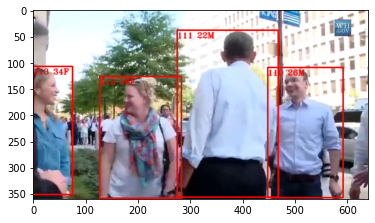

In [ ]:
plt.imshow(global_final_arr[68])